In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import random
import string
import tensorflow as tf
import tensorflow.python.ops.rnn_cell 
from tensorflow.python.framework import registry
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import collections
import matplotlib.pyplot as plt
import codecs
import time
import os
import gc
from six.moves import cPickle as pickle
import sys

from plot_module import text_plot
from plot_module import structure_vocabulary_plots
from plot_module import text_boundaries_plot
from plot_module import ComparePlots

from model_module import maybe_download
from model_module import read_data
from model_module import check_not_one_byte
from model_module import id2char
from model_module import char2id
from model_module import BatchGenerator
from model_module import characters
from model_module import batches2string
from model_module import logprob
from model_module import sample_distribution
from model_module import MODEL

version = sys.version_info[0]

In [2]:
if not os.path.exists('enwik8_filtered'):
    if not os.path.exists('enwik8'):
        filename = maybe_download('enwik8.zip', 36445475)
    full_text = read_data(filename)
    new_text = u""
    new_text_list = list()
    for i in range(len(full_text)):
        if (i+1) % 10000000 == 0:
            print("%s characters are filtered" % i)
        if ord(full_text[i]) < 256:
            new_text_list.append(full_text[i])
    text = new_text.join(new_text_list)
    del new_text_list
    del new_text
    del full_text

    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)

    print("number of not one byte characters: ", not_one_byte_counter) 
    print("min order index: ", min_character_order_index)
    print("max order index: ", max_character_order_index)
    print("total number of characters: ", number_of_characters)
    
    f = open('enwik8_filtered', 'wb')
    f.write(text.encode('utf8'))
    f.close()
    
else:
    f = open('enwik8_filtered', 'rb')
    text = f.read().decode('utf8')
    f.close() 
    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)
  

In [3]:
#different
offset = 10000
valid_size = 2250
valid_text = text[offset:offset+valid_size]
train_text = text[offset+valid_size:]
train_size = len(train_text)


In [4]:
vocabulary_size = number_of_characters
vocabulary = list()
characters_positions_in_vocabulary = list()

character_position_in_vocabulary = 0
for i in range(256):
    if present_characters_indices[i]:
        if version >= 3:
            vocabulary.append(chr(i))
        else:
            vocabulary.append(unichr(i))
        characters_positions_in_vocabulary.append(character_position_in_vocabulary)
        character_position_in_vocabulary += 1
    else:
        characters_positions_in_vocabulary.append(-1)


string_vocabulary = u""
for i in range(vocabulary_size):
    string_vocabulary += vocabulary[i]


In [5]:
batch_size_test=64
num_unrollings_test=10

train_batches_test = BatchGenerator(train_text,
                                    batch_size_test,
                                    vocabulary_size,
                                    characters_positions_in_vocabulary,
                                    num_unrollings_test)
valid_batches_test = BatchGenerator(valid_text,
                                    1,
                                    vocabulary_size,
                                    characters_positions_in_vocabulary,
                                    1)


In [6]:
indices_GL = {"batch_size": 0,
              "num_unrollings": 1,
              "num_layers": 2,
              "num_nodes": 3,
              "half_life": 4,
              "decay": 5,
              "num_steps": 6,
              "averaging_number": 7,
              "type": 8}


class reverse(MODEL):
    def first_or_middle_layer(self, 
                              inp_t_or_mem_down_t_minus_1,
                              mem_up_t_minus_1,
                              out_or_rem_down_t_minus_1,
                              rem_up_t_minus_1,
                              state_t_minus_1,
                              layer_num):
        X_t = tf.concat([inp_t_or_mem_down_t_minus_1,
                         mem_up_t_minus_1,
                         out_or_rem_down_t_minus_1,
                         rem_up_t_minus_1],
                        1)
        RES = tf.matmul(X_t, self.Matrices[layer_num]) + self.Biases[layer_num]
        i, f, o_or_r_down, r_up, j = tf.split(RES, 5, 1)
        i_gate = tf.sigmoid(i)
        f_gate = tf.sigmoid(f)
        r_up_gate = tf.sigmoid(r_up)
        o_or_r_down_gate = tf.sigmoid(o_or_r_down)
        state_t = f_gate * state_t_minus_1 + i_gate * tf.tanh(j)
        TANH_STATE = tf.tanh(state_t)
        out_or_rem_down_t = o_or_r_down_gate * TANH_STATE
        rem_up_t = r_up_gate * TANH_STATE
        one_layer_gates = tf.concat([i_gate, f_gate, o_or_r_down_gate, r_up_gate], 1)
        return out_or_rem_down_t, state_t, rem_up_t, one_layer_gates
    
    def last_layer(self,
                   mem_down_t_minus_1,
                   rem_down_t_minus_1,
                   state_t_minus_1):
        X_t = tf.concat([mem_down_t_minus_1, rem_down_t_minus_1], 1)
        RES = tf.matmul(X_t, self.Matrices[-1]) + self.Biases[-1]
        i, f, r_down, j = tf.split(RES, 4, axis=1)
        i_gate = tf.sigmoid(i)
        f_gate = tf.sigmoid(f)
        r_down_gate = tf.sigmoid(r_down)  
        state_t = f_gate * state_t_minus_1 + i_gate * tf.tanh(j)
        TANH_STATE = tf.tanh(state_t)
        rem_down_t = r_down_gate * TANH_STATE
        one_layer_gates = tf.concat([i_gate, f_gate, r_down_gate], 1)
        return rem_down_t, state_t, one_layer_gates
    
    def iteration(self, inp, state):
        num_layers = len(state)
        new_state = list()
        gates = list()
        out, inter_state, rem_up, layer_gates = self.first_or_middle_layer(inp,
                                                                           state[1][0],
                                                                           state[0][0],
                                                                           state[0][2],
                                                                           state[0][1],
                                                                           0)
        new_state.append((out, inter_state, rem_up))
        gates.append(layer_gates)
        if num_layers > 2:
            for i in range(num_layers-2):
                rem_down, inter_state, rem_up, layer_gates = self.first_or_middle_layer(state[i][2],
                                                                                        state[i+2][0],
                                                                                        state[i+1][0],
                                                                                        state[i+1][2],
                                                                                        state[i+1][1],
                                                                                        i+1)
                new_state.append((rem_down, inter_state, rem_up))
                gates.append(layer_gates)
        rem_down, inter_state, layer_gates = self.last_layer(state[-2][2],
                                                             state[-1][0],
                                                             state[-1][1])
        new_state.append((rem_down, inter_state))
        gates.append(layer_gates)
        return out, new_state, tf.concat(gates, 1)
    
    def __init__(self,
                 batch_size,
                 vocabulary,
                 characters_positions_in_vocabulary,
                 num_unrollings,
                 num_layers,
                 num_nodes,
                 train_text,
                 valid_text):
        self._results = list()
        self._batch_size = batch_size
        self._vocabulary = vocabulary
        self._vocabulary_size = len(vocabulary)
        self._characters_positions_in_vocabulary = characters_positions_in_vocabulary
        self._num_unrollings = num_unrollings
        self._num_layers = num_layers
        self._num_nodes = num_nodes
        self._train_text = train_text
        self._valid_text = valid_text
        self._valid_size = len(valid_text)
        self._indices = {"batch_size": 0,
                         "num_unrollings": 1,
                         "num_layers": 2,
                         "num_nodes": 3,
                         "half_life": 4,
                         "decay": 5,
                         "num_steps": 6,
                         "averaging_number": 7,
                         "type": 8}
        self._graph = tf.Graph()
        
        self._last_num_steps = 0
        with self._graph.as_default():
            self._global_step = tf.Variable(0)
            with self._graph.device('/gpu:0'): 
                self.Matrices = list()
                self.Biases = list()
                self.Matrices.append(tf.Variable(tf.truncated_normal([self._vocabulary_size + 2*self._num_nodes[0] + self._num_nodes[1],
                                                                      5 * self._num_nodes[0]],
                                                                     mean=-0.1, stddev=0.1)))
                self.Biases.append(tf.Variable(tf.zeros([5 * self._num_nodes[0]])))
                if self._num_layers > 2:
                    for i in range(self._num_layers - 2):
                        self.Matrices.append(tf.Variable(tf.truncated_normal([self._num_nodes[i] + 2*self._num_nodes[i+1] + self._num_nodes[i+2],
                                                                              5 * self._num_nodes[i+1]],
                                                                             mean=-0.1, stddev=0.1)))
                        self.Biases.append(tf.Variable(tf.zeros([5 * self._num_nodes[i+1]])))
                self.Matrices.append(tf.Variable(tf.truncated_normal([self._num_nodes[-1] + self._num_nodes[-2],
                                                                      4 * self._num_nodes[-1]],
                                                                     mean=-0.1, stddev=0.1)))     
                self.Biases.append(tf.Variable(tf.zeros([4 * self._num_nodes[-1]])))


                # classifier 
                weights = tf.Variable(tf.truncated_normal([self._num_nodes[0], self._vocabulary_size], stddev = 0.1))
                bias = tf.Variable(tf.zeros([self._vocabulary_size]))
                
                """PLACEHOLDERS train data"""
                self._train_data = list()
                for _ in range(self._num_unrollings + 1):
                    self._train_data.append(
                        tf.placeholder(tf.float32, shape=[self._batch_size, self._vocabulary_size]))
                train_inputs = self._train_data[: self._num_unrollings]
                train_labels = self._train_data[1:]  # labels are inputs shifted by one time step.
                # Unrolled LSTM loop.

                saved_state = list()
                for i in range(self._num_layers-1):
                    saved_state.append((tf.Variable(tf.zeros([self._batch_size, self._num_nodes[i]]), trainable=False),
                                        tf.Variable(tf.zeros([self._batch_size, self._num_nodes[i]]), trainable=False),
                                        tf.Variable(tf.zeros([self._batch_size, self._num_nodes[i]]), trainable=False)))
                saved_state.append((tf.Variable(tf.zeros([self._batch_size, self._num_nodes[-1]]), trainable=False),
                                    tf.Variable(tf.zeros([self._batch_size, self._num_nodes[-1]]), trainable=False)))

                outputs = list()
                state = saved_state
                for i in train_inputs:
                    output, state, _ = self.iteration(i, state)
                    outputs.append(output)

                save_list = list()
                for i in range(self._num_layers-1):
                    save_list.append(saved_state[i][0].assign(state[i][0]))
                    save_list.append(saved_state[i][1].assign(state[i][1]))
                    save_list.append(saved_state[i][2].assign(state[i][2]))
                save_list.append(saved_state[-1][0].assign(state[-1][0]))
                save_list.append(saved_state[-1][1].assign(state[-1][1]))
                
                """skip operation"""
                self._skip_operation = tf.group(*save_list)

                with tf.control_dependencies(save_list):
                        # Classifier.
                    logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), weights, bias)
                    """loss"""
                    self._loss = tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(
                        labels=tf.concat(train_labels, 0), logits=logits))
                # Optimizer.
                
                """PLACEHOLDERS half life and decay"""
                self._half_life = tf.placeholder(tf.int32)
                self._decay = tf.placeholder(tf.float32)
                """learning rate"""
                self._learning_rate = tf.train.exponential_decay(10.0,
                                                                 self._global_step,
                                                                 self._half_life,
                                                                 self._decay,
                                                                 staircase=True)
                optimizer = tf.train.GradientDescentOptimizer(self._learning_rate)
                gradients, v = zip(*optimizer.compute_gradients(self._loss))
                gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
                """optimizer"""
                self._optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=self._global_step)
                """train prediction"""
                self._train_prediction = tf.nn.softmax(logits)

                # Sampling and validation eval: batch 1, no unrolling.
                saved_sample_state = list()
                for i in range(self._num_layers-1):
                    saved_sample_state.append((tf.Variable(tf.zeros([1, self._num_nodes[i]]), trainable=False),
                                               tf.Variable(tf.zeros([1, self._num_nodes[i]]), trainable=False),
                                               tf.Variable(tf.zeros([1, self._num_nodes[i]]), trainable=False)))
                saved_sample_state.append((tf.Variable(tf.zeros([1, self._num_nodes[-1]]), trainable=False),
                                           tf.Variable(tf.zeros([1, self._num_nodes[-1]]), trainable=False))) 
                """PLACEHOLDER sample input"""
                self._sample_input = tf.placeholder(tf.float32, shape=[1, self._vocabulary_size])

                reset_list = list()
                for i in range(self._num_layers-1):
                    reset_list.append(saved_sample_state[i][0].assign(tf.zeros([1, self._num_nodes[i]])))
                    reset_list.append(saved_sample_state[i][1].assign(tf.zeros([1, self._num_nodes[i]])))
                    reset_list.append(saved_sample_state[i][2].assign(tf.zeros([1, self._num_nodes[i]])))
                reset_list.append(saved_sample_state[-1][0].assign(tf.zeros([1, self._num_nodes[-1]])))
                reset_list.append(saved_sample_state[-1][1].assign(tf.zeros([1, self._num_nodes[-1]])))
                """reset sample state"""
                self._reset_sample_state = tf.group(*reset_list)

                sample_output, sample_state, self.gates = self.iteration(self._sample_input, saved_sample_state)

                sample_save_list = list()
                for i in range(self._num_layers-1):
                    sample_save_list.append(saved_sample_state[i][0].assign(sample_state[i][0]))
                    sample_save_list.append(saved_sample_state[i][1].assign(sample_state[i][1])) 
                    sample_save_list.append(saved_sample_state[i][2].assign(sample_state[i][2])) 
                sample_save_list.append(saved_sample_state[-1][0].assign(sample_state[-1][0]))
                sample_save_list.append(saved_sample_state[-1][1].assign(sample_state[-1][1]))

                with tf.control_dependencies(sample_save_list):
                    """sample prediction"""
                    self._sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, weights, bias)) 
                
                """Matrices = list()
                Biases = list()
                gates = list()
                with tf.variable_scope(LSTM_scope, reuse=True):
                    for i in range(self._num_layers):
                        with tf.variable_scope("Cell%d" % i):
                            with tf.variable_scope("BasicLSTMCell/Linear"):
                                Matrices.append(tf.get_variable("Matrix"))
                                Biases.append(tf.get_variable("Bias"))
                cur_inp = self._sample_input
                for layer_num in range(self._num_layers):
                    concat = tf.matmul(tf.concat(1, [cur_inp,
                                                     saved_sample_state[layer_num][1]]),
                                       Matrices[layer_num]) + Biases[layer_num]
                    i, _, f, o = tf.split(1, 4, concat)
                    gates.append(tf.concat(0,
                                           [tf.sigmoid(i),
                                            tf.sigmoid(f),
                                            tf.sigmoid(o)]))
                    with tf.variable_scope(LSTM_scope, reuse=True):
                        with tf.variable_scope("Cell%d" % layer_num):
                            cur_inp, _ = cell_list[layer_num](cur_inp, saved_sample_state[layer_num])
                    
                #gates
                self.gates = tf.pack(gates)"""
                
                """saver"""
            self.saver = tf.train.Saver(max_to_keep=None)
                            
                        
    
    def _generate_metadata(self, half_life, decay, num_averaging_iterations):
        metadata = list()
        metadata.append(self._batch_size)
        metadata.append(self._num_unrollings)
        metadata.append(self._num_layers)
        metadata.append(self._num_nodes)
        metadata.append(half_life)
        metadata.append(decay)
        metadata.append(self._last_num_steps)
        metadata.append(num_averaging_iterations)
        metadata.append('reverse')
        return metadata
        
        
    def get_gates(self, session, num_strings=10, length=75, start_positions=None):
        self._reset_sample_state.run()
        self._valid_batches = BatchGenerator(self._valid_text,
                                             1,
                                             self._vocabulary_size,
                                             self._characters_positions_in_vocabulary,
                                             1)
        if start_positions is None:
            start_positions = list()
            if self._valid_size / num_strings < length:
                num_strings = self._valid_size / length
            for i in range(num_strings):
                start_positions.append(i* (self._valid_size / num_strings) + self._valid_size / num_strings / 2)
            while self._valid_size - start_positions[-1] < length:
                del start_positions[-1]
        text_list = list()
        gate_dict = dict()
        aver_gate_dict = dict()
        first_order = ['i', 'f', 'd', 'u']
        second_order = ['i', 'f', 'd']
        for layer_idx in range(self._num_layers-1):
            gate_dict[layer_idx+1] = {'i': list(), 'f': list(), 'd': list(), 'u': list()}
            aver_gate_dict[layer_idx+1] = {'i': list(), 'f': list(), 'd': list(), 'u': list()}
        gate_dict[self._num_layers] = {'i': list(), 'f': list(), 'd': list()}
        aver_gate_dict[self._num_layers] = {'i': list(), 'f': list(), 'd': list()}
        collect_gates = False
        letters_parsed = -1
        for idx in range(self._valid_size):
            b = self._valid_batches.next()
            
            if idx in start_positions or collect_gates: 
                if letters_parsed == -1:
                    letters_parsed = 0
                    text = u""
                    g_dict = dict()
                    for layer_idx in range(self._num_layers-1):
                        g_dict[layer_idx+1] = {'i': [list() for _ in range(self._num_nodes[layer_idx])],
                                               'f': [list() for _ in range(self._num_nodes[layer_idx])],
                                               'd': [list() for _ in range(self._num_nodes[layer_idx])],
                                               'u': [list() for _ in range(self._num_nodes[layer_idx])]}
                    g_dict[self._num_layers] = {'i': [list() for _ in range(self._num_nodes[self._num_layers-1])],
                                                  'f': [list() for _ in range(self._num_nodes[self._num_layers-1])],
                                                  'd': [list() for _ in range(self._num_nodes[self._num_layers-1])]}
                    av_g_dict = dict()
                    for layer_idx in range(self._num_layers-1):
                        av_g_dict[layer_idx+1] = {'i': list(),
                                                  'f': list(),
                                                  'd': list(),
                                                  'u': list()}
                    av_g_dict[self._num_layers] = {'i': list(),
                                                     'f': list(),
                                                     'd': list()}
                    collect_gates = True
                text += characters(b[0], self._vocabulary)[0]
                iteration_gates = self.gates.eval({self._sample_input: b[0]})
                num_gates = iteration_gates.shape[0]
                #print('num_gates: ', num_gates)
                gates_by_layer = list()
                av_gates_by_layer = list()
                start = 0
                for layer_idx in range(self._num_layers-1):
                    stop = start + self._num_nodes[layer_idx] * 4
                    layer_gates = iteration_gates[:, start : stop]
                    layer_gates_list = list()
                    av_layer_gates_list = list()
                    for gate_idx in range(4):
                        layer_gates_list.append(
                            list(
                                np.squeeze(
                                    layer_gates[:, gate_idx * self._num_nodes[layer_idx] : (gate_idx+1) * self._num_nodes[layer_idx]])))
                        av_layer_gates_list.append(
                            np.mean(
                                layer_gates[:, gate_idx * self._num_nodes[layer_idx] : (gate_idx+1) * self._num_nodes[layer_idx]]))
                    gates_by_layer.append(layer_gates_list)
                    av_gates_by_layer.append(av_layer_gates_list)
                    start += self._num_nodes[layer_idx]

                layer_gates = iteration_gates[:, start : ]
                layer_gates_list = list()
                av_layer_gates_list = list()
                for gate_idx in range(3):
                    layer_gates_list.append(
                        list(
                            np.squeeze(
                                layer_gates[:, gate_idx * self._num_nodes[layer_idx] : (gate_idx+1) * self._num_nodes[layer_idx]])))
                    av_layer_gates_list.append(
                        np.mean(
                            layer_gates[:, gate_idx * self._num_nodes[layer_idx] : (gate_idx+1) * self._num_nodes[layer_idx]]))
                gates_by_layer.append(layer_gates_list)
                av_gates_by_layer.append(av_layer_gates_list)
                
                for layer_idx in range(self._num_layers-1):
                    #print(av_g_dict[layer_idx+1].keys())
                    for gate_idx, gate_type in enumerate(first_order):
                        av_g_dict[layer_idx+1][gate_type].append(av_gates_by_layer[layer_idx][gate_idx])
                        #print(len(gates_by_layer[layer_idx][gate_idx]))
                        for node_idx, node_value in enumerate(gates_by_layer[layer_idx][gate_idx]):
                            #print(node_idx)
                            g_dict[layer_idx+1][gate_type][node_idx].append(node_value)
                for gate_idx, gate_type in enumerate(second_order):
                    av_g_dict[self._num_layers][gate_type].append(av_gates_by_layer[self._num_layers-1][gate_idx])
                    for node_idx, node_value in enumerate(gates_by_layer[self._num_layers-1][gate_idx]):
                        g_dict[self._num_layers][gate_type][node_idx].append(node_value)
                letters_parsed += 1
                if letters_parsed >= length:
                    collect_gates = False
                    for layer_key in gate_dict.keys():
                        for gate_key in gate_dict[layer_key].keys():
                            gate_dict[layer_key][gate_key].append(g_dict[layer_key][gate_key])
                            aver_gate_dict[layer_key][gate_key].append(av_g_dict[layer_key][gate_key])
                    text_list.append(text)
                    letters_parsed = -1
                    
            _ = self._sample_prediction.eval({self._sample_input: b[0]})
        return text_list, gate_dict, aver_gate_dict    

In [7]:
model = reverse(64,
                 vocabulary,
                 characters_positions_in_vocabulary,
                 10,
                 2,
                 [64, 64],
                 train_text,
                 valid_text)

In [8]:

model.run(1,                # number of times learning_rate is decreased
          0.9,              # a factor by which learning_rate is decreased
            50,            # each 'train_frequency' steps loss and percent correctly predicted letters is calculated
            100,             # minimum number of times loss and percent correctly predicted letters are calculated while learning (train points)
            3,              # if during half total spent time loss decreased by less than 'stop_percent' percents learning process is stopped
            1,              # when train point is obtained validation may be performed
            5,             # when train point percent is calculated results got on averaging_number chunks are averaged
          fixed_number_of_steps=2000,
          print_intermediate_results=True,
          save_path="reverse/validation_perplexity_test")

"""add_operations=['self.L2_train'],
print_steps=[10, 50, 200],
validation_add_operations = ['self.L2_validation'],
num_validation_prints=10,
print_intermediate_results = True,
summarizing_logdir=logdir"""

Initialized
Average loss at step 0: 5.286508 learning rate: 10.000000
Percentage_of correct: 0.00%

random:
¿×u2¿£.ä^
n8H%ÿ<ÏF3#Ì|Öe½,´^ÖnO¦TÇc6ÅáÒà2ù ¯' cHBeaêII[äâbít áQ?ôd_\&¢þIrBGÔ×ÛÔ
¬åöÊ4ÅÛL(g=þÏâ9»#ËÑªlCb¶Ze	Ð*±0òTylBØ±«iÁBdëùÔ·ïNìæ,¥L£íAÀ
î*:æ+?Óå0 ê%õ¡CVët<]d
æ}ªÞLßný+à0¤b°ÿLöuÀES v&*Û$Ó&Ý"ï9e+rªe¹îoÀ(a(eH[øBó»ÍÅÉÈzµ}Ñ¨ßíõGÑ7æìà¬êFGÞ;8ýC
(¼RIÏrÊ	ô}Gw6z94-] ñ9" W¬/{èøöf'bØØcÕä¸ñaûÍsT#tûjóØØFmu§oñoüàÿm:Îèþ¬\ÛÃÝvº ^Á<
IzÂ!×Ûóm'DHaÚñö*eã¹ ãGR +´µùWÆÇÒIñ½¾h¤A.ºKs±|²§D'ÀLN¾TØùÊFk ø[²È¼Úì¿°ø}o s'ÎÚ#? 
Validation percentage of correct: 12.00%

step:  9
average_percentage_of_correct = 8.90625
step:  19
average_percentage_of_correct = 20.625
step:  29
average_percentage_of_correct = 37.34375
step:  39
average_percentage_of_correct = 51.875
step:  49
average_percentage_of_correct = 67.96875
Average loss at step 50: 3.758833 learning rate: 10.000000
Percentage_of correct: 13.59%
Validation percentage of correct: 12.13%

step:  59
average_percentage_of_correct = 13.4375
step:  69
avera

Validation percentage of correct: 36.22%

step:  909
average_percentage_of_correct = 41.5625
step:  919
average_percentage_of_correct = 85.3125
step:  929
average_percentage_of_correct = 125.3125
step:  939
average_percentage_of_correct = 166.40625
step:  949
average_percentage_of_correct = 207.34375
Average loss at step 950: 2.104524 learning rate: 10.000000
Percentage_of correct: 41.47%
Validation percentage of correct: 38.67%

step:  959
average_percentage_of_correct = 39.6875
step:  969
average_percentage_of_correct = 81.5625
step:  979
average_percentage_of_correct = 124.53125
step:  989
average_percentage_of_correct = 166.09375
step:  999
average_percentage_of_correct = 208.125
Average loss at step 1000: 2.106792 learning rate: 10.000000
Percentage_of correct: 41.62%

random:
distwan sell gravee, Indersuration repave needs there be with a irsterm of the 
#drechan (the Crust also whomand the of his chilluplism madehed nemmus inverbord
ÈD the filmich vetcich wings also nhwlies of 

Validation percentage of correct: 44.18%

step:  1809
average_percentage_of_correct = 50.15625
step:  1819
average_percentage_of_correct = 97.03125
step:  1829
average_percentage_of_correct = 143.90625
step:  1839
average_percentage_of_correct = 186.09375
step:  1849
average_percentage_of_correct = 233.59375
Average loss at step 1850: 1.932652 learning rate: 10.000000
Percentage_of correct: 46.72%
Validation percentage of correct: 44.62%

step:  1859
average_percentage_of_correct = 46.875
step:  1869
average_percentage_of_correct = 96.25
step:  1879
average_percentage_of_correct = 139.6875
step:  1889
average_percentage_of_correct = 187.34375
step:  1899
average_percentage_of_correct = 232.8125
Average loss at step 1900: 1.866088 learning rate: 10.000000
Percentage_of correct: 46.56%
Validation percentage of correct: 44.49%

step:  1909
average_percentage_of_correct = 45.15625
step:  1919
average_percentage_of_correct = 96.40625
step:  1929
average_percentage_of_correct = 141.5625
step

"add_operations=['self.L2_train'],\nprint_steps=[10, 50, 200],\nvalidation_add_operations = ['self.L2_validation'],\nnum_validation_prints=10,\nprint_intermediate_results = True,\nsummarizing_logdir=logdir"

In [9]:
model.plot_all([0],
               plot_validation=True,
               indent=4,
               save_folder='reverse/validation_perplexity/b64minexp',
               show=False)

In [8]:
model.simple_run(100,              #minimum number of steps
                             'reverse/variables/for_gates',               #how often average loss is calculated
                             20000,               #number of steps to be performed before nex try to stop learning
                             4000,
                             5000,#number times learning rate will decay
                             20,                #decay
                             0.9,                  #stop percent
                             3)

Number of steps = 25001     Percentage = 53.86%     Time = 608s     Learning rate = 0.7179


In [45]:
text_list, gate_dict, aver_gate_dict = model.run_for_analitics(model.get_gates,
                                                'reverse/variables/for_gates',
                                                [300, 75, None])

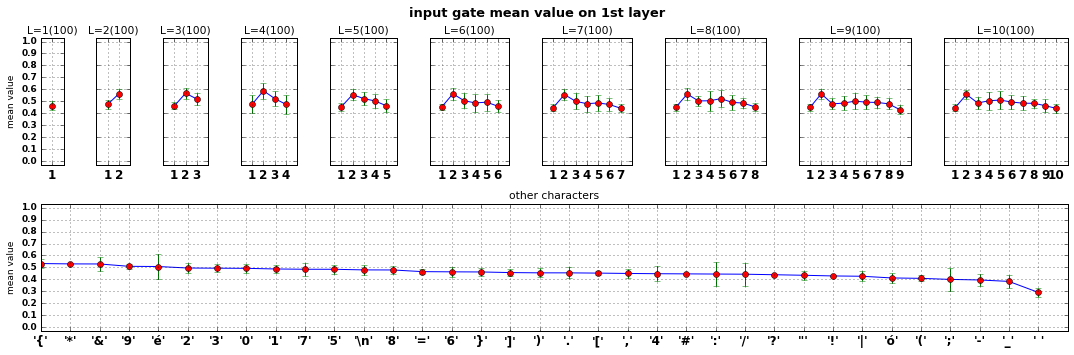

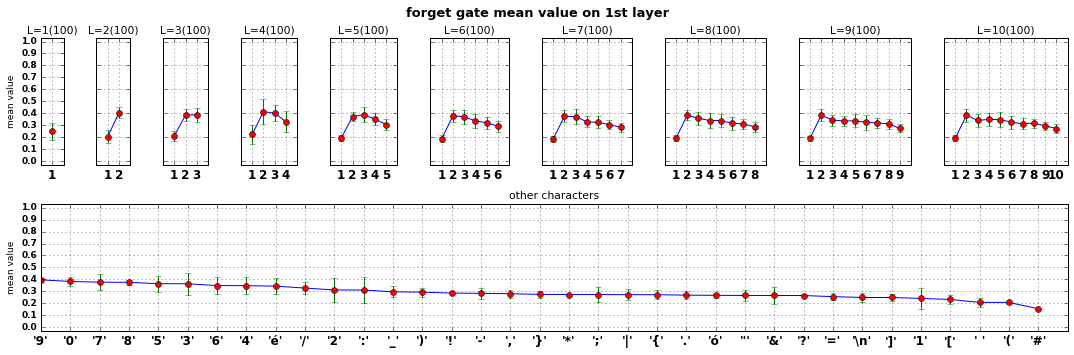

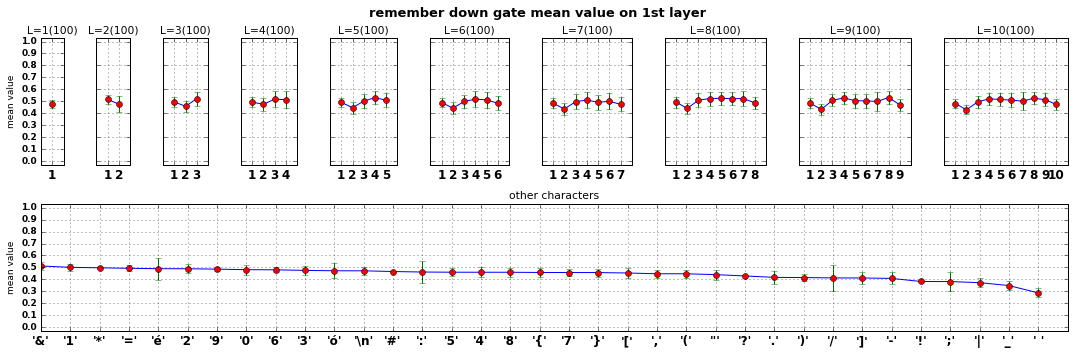

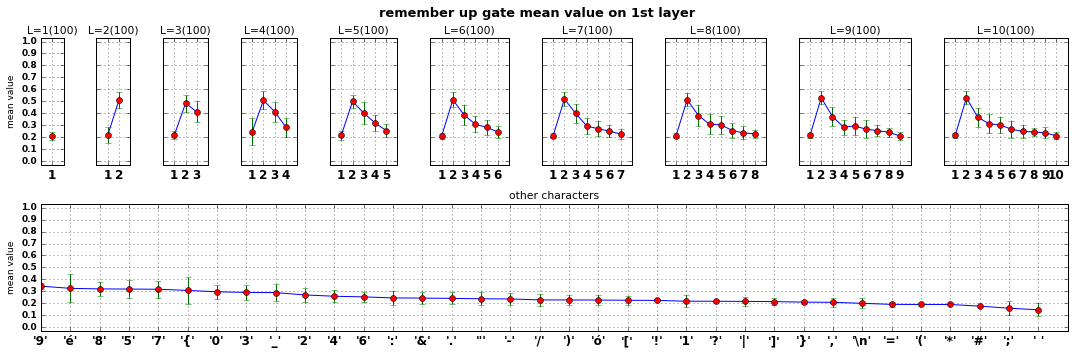

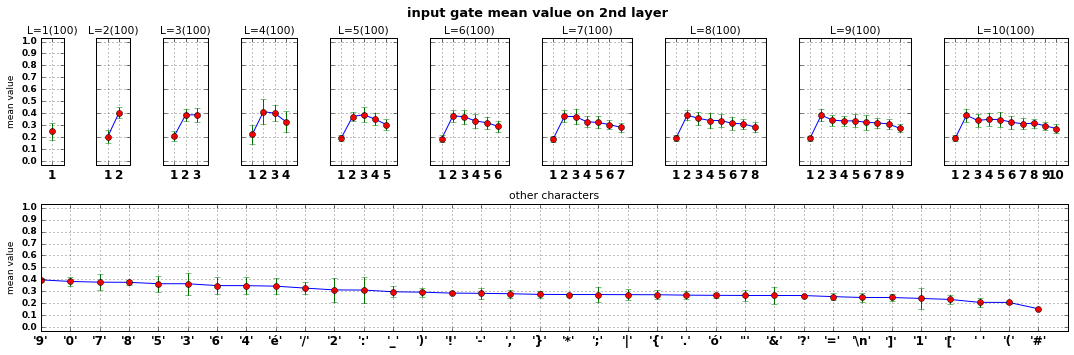

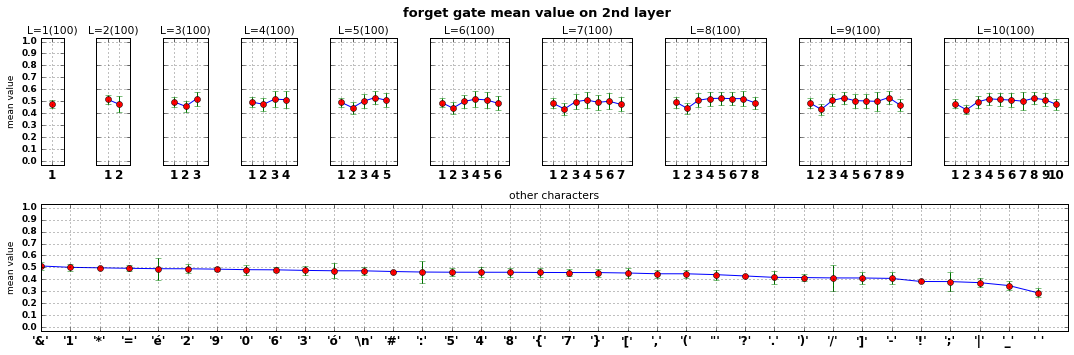

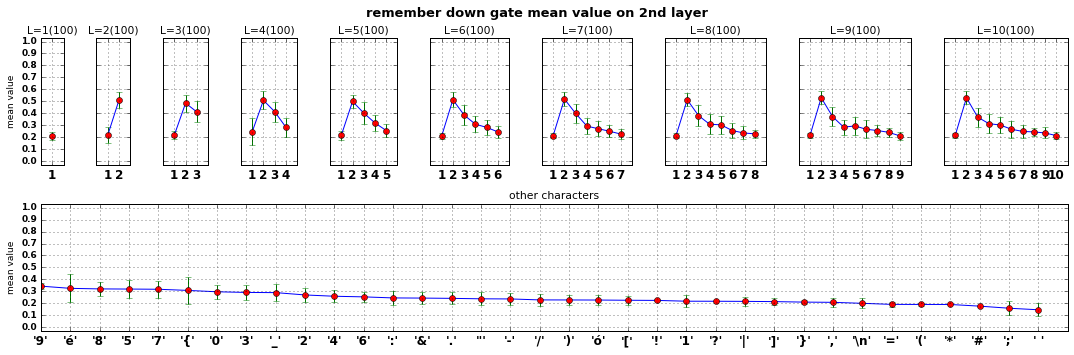

In [46]:
structure_vocabulary_plots(text_list,
                           aver_gate_dict[1]['i'],
                           'input gate mean value on 1st layer',
                           'mean value',
                           ['reverse', 'gates', 'vocabulary'],
                           'mean_input1_64_16_nu_10',
                           ylims=[0., 1.],
                           ylims_fixed=True,
                           show=True)  
structure_vocabulary_plots(text_list,
                           aver_gate_dict[1]['f'],
                           'forget gate mean value on 1st layer',
                           'mean value',
                           ['reverse', 'gates', 'vocabulary'],
                           'mean_forget1_64_16_nu_10',
                           ylims=[0., 1.],
                           ylims_fixed=True,
                           show=True) 
structure_vocabulary_plots(text_list,
                           aver_gate_dict[1]['d'],
                           'remember down gate mean value on 1st layer',
                           'mean value',
                           ['reverse', 'gates', 'vocabulary'],
                           'mean_remember_down1_64_16_nu_10',
                           ylims=[0., 1.],
                           ylims_fixed=True,
                           show=True) 
structure_vocabulary_plots(text_list,
                           aver_gate_dict[1]['u'],
                           'remember up gate mean value on 1st layer',
                           'mean value',
                           ['reverse', 'gates', 'vocabulary'],
                           'mean_remember_up1_64_16_nu_10',
                           ylims=[0., 1.],
                           ylims_fixed=True,
                           show=True) 
structure_vocabulary_plots(text_list,
                           aver_gate_dict[2]['i'],
                           'input gate mean value on 2nd layer',
                           'mean value',
                           ['reverse', 'gates', 'vocabulary'],
                           'mean_input2_64_16_nu_10',
                           ylims=[0., 1.],
                           ylims_fixed=True,
                           show=True)  
structure_vocabulary_plots(text_list,
                           aver_gate_dict[2]['f'],
                           'forget gate mean value on 2nd layer',
                           'mean value',
                           ['reverse', 'gates', 'vocabulary'],
                           'mean_forget2_64_16_nu_10',
                           ylims=[0., 1.],
                           ylims_fixed=True,
                           show=True) 
structure_vocabulary_plots(text_list,
                           aver_gate_dict[2]['d'],
                           'remember down gate mean value on 2nd layer',
                           'mean value',
                           ['reverse', 'gates', 'vocabulary'],
                           'mean_remember_down2_64_16_nu_10',
                           ylims=[0., 1.],
                           ylims_fixed=True,
                           show=True)

In [48]:
for i in range(50):
    text_plot(text_list[i],
          aver_gate_dict[1]['i'][i],
          'input gate',
          'input gate',
          ['reverse', 'gates', 'text_plots', 'input1'],
          'inp1_64_16_nu_10#%s' % i,
          show=False)
    text_plot(text_list[i],
          aver_gate_dict[1]['f'][i],
          'forget gate',
          'forget gate',
          ['reverse', 'gates', 'text_plots', 'forget1'],
          'forget1_64_16_nu_10#%s' % i,
          show=False)
    text_plot(text_list[i],
          aver_gate_dict[1]['d'][i],
          'remember down gate',
          'remember down gate',
          ['reverse', 'gates', 'text_plots', 'remember_down1'],
          'remember_down1_64_16_nu_10#%s' % i,
          show=False)
    text_plot(text_list[i],
          aver_gate_dict[1]['u'][i],
          'remember up gate',
          'remember up gate',
          ['reverse', 'gates', 'text_plots', 'remember_up1'],
          'remember_up1_64_16_nu_10#%s' % i,
          show=False)
    text_plot(text_list[i],
          aver_gate_dict[2]['i'][i],
          'output gate',
          'output gate',
          ['reverse', 'gates', 'text_plots', 'input2'],
          'output1_64_16_nu_10#%s' % i,
          show=False)
    text_plot(text_list[i],
          aver_gate_dict[2]['f'][i],
          'forget gate',
          'forget gate',
          ['reverse', 'gates', 'text_plots', 'forget2'],
          'forget1_64_16_nu_10#%s' % i,
          show=False)
    text_plot(text_list[i],
          aver_gate_dict[2]['d'][i],
          'remember down gate',
          'remember down gate',
          ['reverse', 'gates', 'text_plots', 'remember_down2'],
          'remember_down1_64_16_nu_10#%s' % i,
          show=False)

In [20]:
num_nodes_values = [16, 32, 48, 64, 96, 128]
num_unrollings_values = [10, 40]

results2_GL = list()
num_nodes = [0, 0]                

for num_nodes[0] in num_nodes_values:
    print(' '*15 + "Number of nodes in 1st layer: ", num_nodes[0])
    for num_nodes[1] in num_nodes_values:
        print(' '*10 + "Number of nodes in 2nd layer: ", num_nodes[1])
        for num_unrollings in num_unrollings_values:
            print(' '*5 + "Number of unrollings: ", num_unrollings)
            model = reverse(64,
                 vocabulary,
                 characters_positions_in_vocabulary,
                 num_unrollings,
                 2,
                 [num_nodes[0], num_nodes[1]],
                 train_text,
                 valid_text)
            model.simple_run(100,              #minimum number of steps
                             'reverse/2/variables/%s_%s_nu%s' % (num_nodes[0], num_nodes[1], num_unrollings),               #how often average loss is calculated
                             40000,               #number of steps to be performed before nex try to stop learning
                             4000,
                             5000,#number times learning rate will decay
                             20,                #decay
                             0.9,                  #stop percent
                             3)            
            results2_GL.extend(model._results)
            model.destroy()
            del model
            gc.collect()

               Number of nodes in 1st layer:  16
          Number of nodes in 2nd layer:  16
     Number of unrollings:  10
Number of steps = 40001     Percentage = 44.62%     Time = 681s     Leraning rate = 1.22
     Number of unrollings:  40
Number of steps = 40001     Percentage = 45.02%     Time = 3500s     Leraning rate = 1.22
          Number of nodes in 2nd layer:  32
     Number of unrollings:  10
Number of steps = 40001     Percentage = 45.60%     Time = 677s     Leraning rate = 1.22
     Number of unrollings:  40
Number of steps = 40001     Percentage = 46.53%     Time = 3569s     Leraning rate = 1.22
          Number of nodes in 2nd layer:  48
     Number of unrollings:  10
Number of steps = 40001     Percentage = 47.03%     Time = 712s     Leraning rate = 1.22
     Number of unrollings:  40
Number of steps = 40001     Percentage = 47.40%     Time = 3800s     Leraning rate = 1.22
          Number of nodes in 2nd layer:  64
     Number of unrollings:  10
Number of steps = 400

In [7]:
folder_name = 'reverse'
file_name = 'reverse_2.pickle'
force = True
pickle_dump = {'results2_GL': results2_GL}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s.' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

NameError: name 'results2_GL' is not defined

In [8]:
folder_name = 'reverse'
pickle_file = 'reverse_2.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  results2_GL_rev = save['results2_GL']
  del save  # hint to help gc free up memory

In [9]:
indices_GL = {"batch_size": 0,
              "num_unrollings": 1,
              "num_layers": 2,
              "num_nodes": 3,
              "half_life": 4,
              "decay": 5,
              "num_steps": 6,
              "averaging_number": 7,
              "type": 8}

folder_name = 'simple_model'
pickle_file = 'simple_1.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  results1_GL = save['results1_GL']
  del save  # hint to help gc free up memory

In [10]:
folder_name = 'simple_model'
pickle_file = 'simple_2.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  results2_GL = save['results2_GL']
  del save  # hint to help gc free up memory

In [11]:
folder_name = 'simple_model'
pickle_file = 'simple_3.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  results3_GL = save['results3_GL']
  del save  # hint to help gc free up memory

In [12]:
from plot_module import ComparePlots

reverse_plots = ComparePlots('reverse')
reverse_plots.add_network(results2_GL_rev, model._indices)



In [13]:
for result in results1_GL:
    result['metadata'].append('simple')
for result in results2_GL:
    result['metadata'].append('simple')
for result in results3_GL:
    result['metadata'].append('simple')

In [14]:
print(results1_GL[0]['metadata'])

[64, 10, 1, [32], 1000, 0.9, 20001, 100, 'simple']


In [15]:
reverse_plots.add_network(results1_GL, indices_GL)
reverse_plots.add_network(results2_GL, indices_GL)
reverse_plots.add_network(results3_GL, indices_GL)

In [16]:
reverse_plots.new_metadata('reverse_2', 'num_nodes[0]+num_nodes[1]', 'total_nodes')
reverse_plots.new_metadata('simple_2', 'num_nodes[0]+num_nodes[1]', 'total_nodes')
reverse_plots.new_metadata('simple_3', 'num_nodes[0]+num_nodes[1]+num_nodes[2]', 'total_nodes')

1

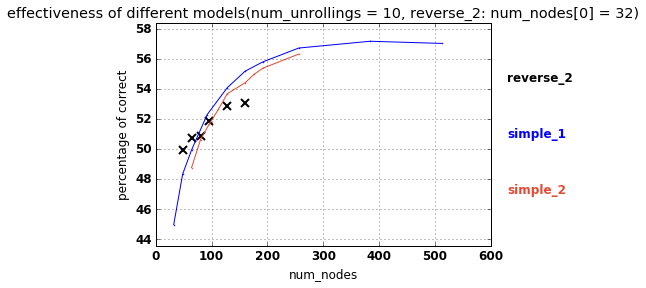

In [23]:
reverse_plots.save_several_networks_plot(['reverse_2', 'simple_1', 'simple_2'],
                                   ['total_nodes', 'num_nodes[0]', 'total_nodes'],
                                   [{'num_unrollings': 10, 'num_nodes[0]': 32}, {'num_unrollings': 10}, {'num_unrollings': 10}],
                                   'num_nodes',
                                   'effectiveness of different models',
                                   [False, True, True],
                                   [False, True, True],
                                   show=True)

In [24]:
reverse_plots.new_metadata('simple_2', 'time/num_steps*1000', 'time_per_1000')
reverse_plots.new_metadata('reverse_2', 'time/num_steps*1000', 'time_per_1000')

1

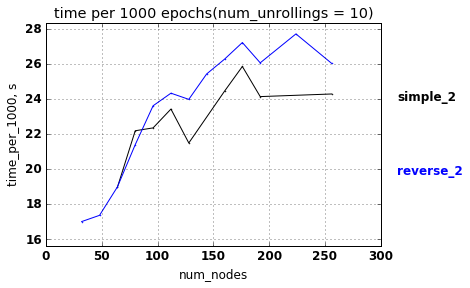

In [25]:
alternative_variable='time_per_1000'
reverse_plots.save_several_networks_plot(['simple_2', 'reverse_2'],
                                ['total_nodes', 'total_nodes'],
                                [{'num_unrollings': 10}, {'num_unrollings': 10}],
                                'num_nodes',
                                'time per 1000 epochs',
                                [True, True],
                                [True, True],
                                percentage=False,
                                alternative_variable=alternative_variable,
                                show=True)

In [26]:
reverse_plots.new_metadata('simple_2', '196+num_nodes[0]', 'M1_1dim')
reverse_plots.new_metadata('reverse_2', '2*num_nodes[0]+196+num_nodes[1]', 'M1_1dim')

reverse_plots.new_metadata('simple_2', '4*num_nodes[0]', 'M1_2dim')
reverse_plots.new_metadata('reverse_2', '5*num_nodes[0]', 'M1_2dim')

reverse_plots.new_metadata('simple_2', 'num_nodes[1]+num_nodes[0]', 'M2_1dim')
reverse_plots.new_metadata('reverse_2', 'num_nodes[1]+num_nodes[0]', 'M2_1dim')

reverse_plots.new_metadata('simple_2', '4*num_nodes[1]', 'M2_2dim')
reverse_plots.new_metadata('reverse_2', '4*num_nodes[1]', 'M2_2dim')

reverse_plots.new_metadata('simple_2', 'M1_1dim*M1_2dim', 'matrix1')
reverse_plots.new_metadata('reverse_2', 'M1_1dim*M1_2dim', 'matrix1')

reverse_plots.new_metadata('simple_2', 'M2_1dim*M2_2dim', 'matrix2')
reverse_plots.new_metadata('reverse_2', 'M2_1dim*M2_2dim', 'matrix2')

1

In [27]:
reverse_plots.new_metadata('simple_2', 'matrix1+matrix2', 'param_num')
reverse_plots.new_metadata('reverse_2', 'matrix1+matrix2', 'param_num')

1

In [28]:
reverse_plots.new_metadata('simple_1', '196+num_nodes[0]', 'M1_1dim')

reverse_plots.new_metadata('simple_1', '4*num_nodes[0]', 'M1_2dim')

reverse_plots.new_metadata('simple_1', 'M1_1dim*M1_2dim', 'matrix1')



1

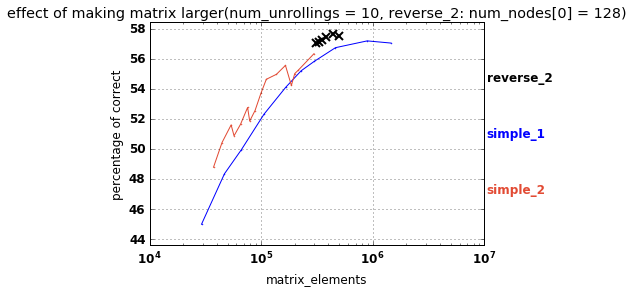

In [35]:
reverse_plots.save_several_networks_plot(['reverse_2', 'simple_1', 'simple_2'],
                                   ['param_num', 'matrix1', 'param_num'],
                                   [{'num_unrollings': 10, 'num_nodes[0]': 128}, {'num_unrollings': 10}, {'num_unrollings': 10}],
                                   'matrix_elements',
                                   'effect of making matrix larger',
                                   [False, True, True],
                                   [False, True, True],
                                   show=True,
                                        plot_options={'x': 'log'})

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


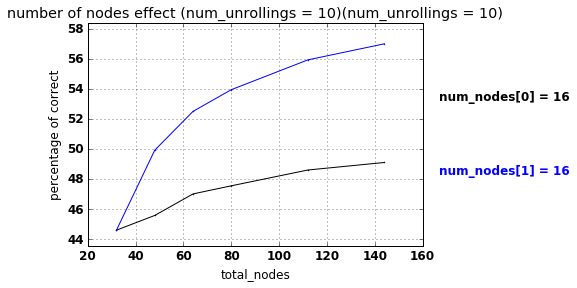

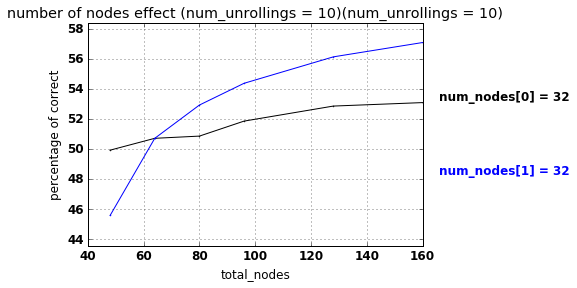

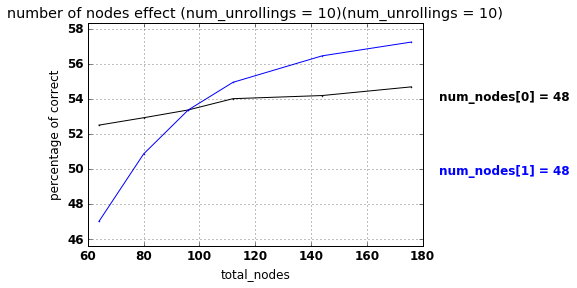

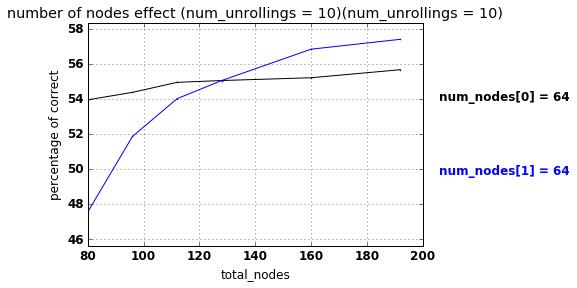

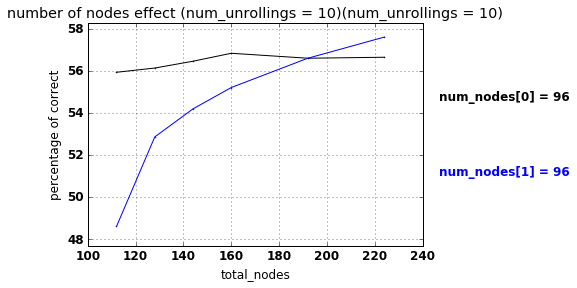

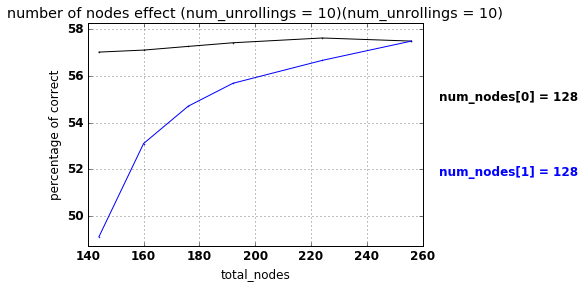

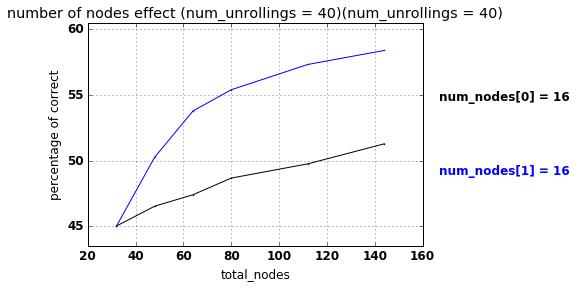

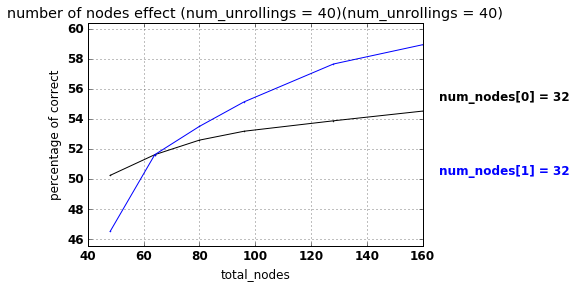

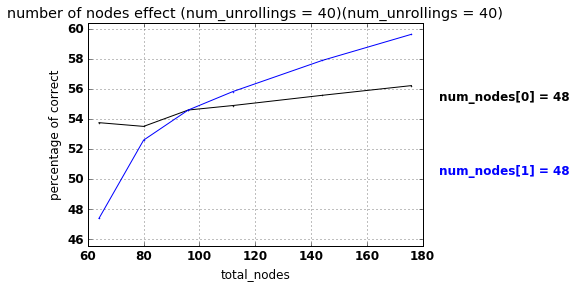

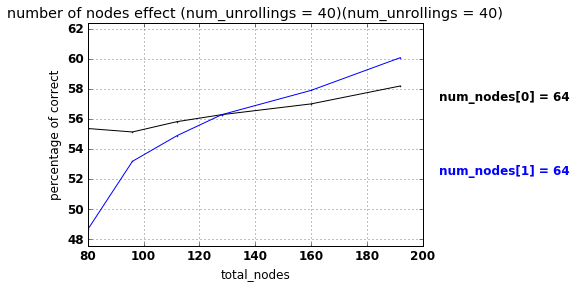

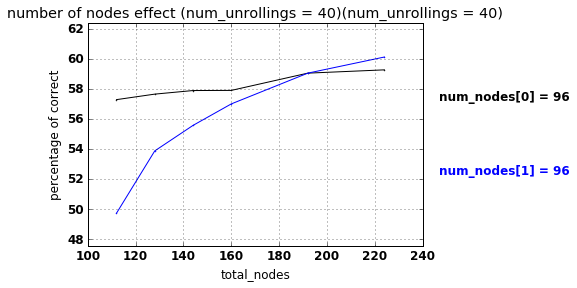

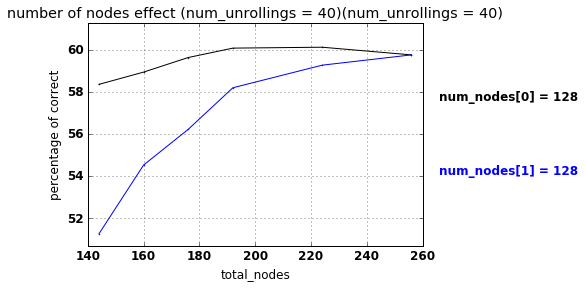

In [12]:
num_nodes_values = [16, 32, 48, 64, 96, 128]
num_unrollings_values = [10, 40]

for nu in num_unrollings_values:
    for nn in num_nodes_values:
        plot_data, _ = reverse_plots.one_key_layout_data('reverse_2',
                                                         'total_nodes',
                                                         {'num_nodes[0]': nn, 'num_nodes[1]': nn},
                                                         limit_variables={'num_unrollings': nu})
        reverse_plots.save_layout(plot_data[0],
                                  'number of nodes effect (num_unrollings = %s)' % nu,
                                  ['reverse', '2', 'num_nodes_effect'],
                                  'nn_%s;nu_%s' % (nn, nu))
        reverse_plots.draw(plot_data[0],
                           'number of nodes effect (num_unrollings = %s)' % nu)

In [14]:
model = reverse(64,
                 vocabulary,
                 characters_positions_in_vocabulary,
                 10,
                 2,
                 [64, 64],
                 train_text,
                 valid_text)

In [15]:
text_list, gate_list = model.run_for_analitics(model.get_gates,
                                                'reverse/2/variables/64_64_nu10',
                                                [100, 75, None])

In [16]:
print('text list length: ', len(text_list))
print('gate_list_length: ', len(gate_list))
print('gates length: ', len(gate_list[0]))
print('gate_shape: ', gate_list[0][0].shape)

text list length:  99
gate_list_length:  99
gates length:  75
gate_shape:  (1, 448)


In [17]:
nn0=64
nn1=64

gates_mean = {0: dict(), 1: dict()}
gates_mean[0]['i'] = list()
gates_mean[0]['f'] = list()
gates_mean[0]['up'] = list()
gates_mean[0]['text'] = list()
gates_mean[1]['i'] = list()
gates_mean[1]['f'] = list()
gates_mean[1]['down'] = list()
gates_mean[1]['text'] = list()

for text_number, text in enumerate(text_list):
    i1 = list()
    f1 = list()
    up1 = list()
    i2 = list()
    f2 = list()
    down2 = list()
    text_gates = gate_list[text_number]
    for text_gate in text_gates:
        gate1 = text_gate[:, :4*nn0]
        gate2 = text_gate[:,4*nn0 :]
        i1.append(np.mean(gate1[:,:nn0]))
        f1.append(np.mean(gate1[:,nn0:2*nn0]))
        up1.append(np.mean(gate1[:,3*nn0:]))
        i2.append(np.mean(gate2[:,:nn1]))
        f2.append(np.mean(gate2[:,nn1:2*nn1]))
        down2.append(np.mean(gate2[:,2*nn1:3*nn1]))
    gates_mean[0]['i'].append(i1)
    gates_mean[0]['f'].append(f1)
    gates_mean[0]['up'].append(up1)
    gates_mean[0]['text'].append(text)
    gates_mean[1]['i'].append(i2[1:])
    gates_mean[1]['f'].append(f2[1:])
    gates_mean[1]['down'].append(down2[1:])
    gates_mean[1]['text'].append(text[:-1])
    #print('input_gate length at %s: ' % text_number, len(input_gate))
    #print('forget_gate length at %s: ' % text_number, len(forget_gate))
#print('input_list: ', input_list)
#print('forget_list: ', forget_list)
print("gates_mean[0]['i'][0]: ", len(gates_mean[0]['i'][0]))
print("gates_mean[0]['f'][0]: ", len(gates_mean[0]['f'][0]))
print("gates_mean[0]['up'][0]: ", len(gates_mean[0]['up'][0]))
print("gates_mean[0]['text'][0]: ", len(gates_mean[0]['text'][0]))
print("gates_mean[1]['i'][0]: ", len(gates_mean[1]['i'][0]))
print("gates_mean[1]['f'][0]: ", len(gates_mean[1]['f'][0]))
print("gates_mean[1]['down'][0]: ", len(gates_mean[1]['down'][0]))
print("gates_mean[1]['text'][0]: ", len(gates_mean[1]['text'][0]))

print("gates_mean[0]['i']: ", len(gates_mean[0]['i']))
print("gates_mean[0]['f']: ", len(gates_mean[0]['f']))
print("gates_mean[0]['up']: ", len(gates_mean[0]['up']))
print("gates_mean[0]['text']: ", len(gates_mean[0]['text']))
print("gates_mean[1]['i']: ", len(gates_mean[1]['i']))
print("gates_mean[1]['f']: ", len(gates_mean[1]['f']))
print("gates_mean[1]['down']: ", len(gates_mean[1]['down']))
print("gates_mean[1]['text']: ", len(gates_mean[1]['text']))

gates_mean[0]['i'][0]:  75
gates_mean[0]['f'][0]:  75
gates_mean[0]['up'][0]:  75
gates_mean[0]['text'][0]:  75
gates_mean[1]['i'][0]:  74
gates_mean[1]['f'][0]:  74
gates_mean[1]['down'][0]:  74
gates_mean[1]['text'][0]:  74
gates_mean[0]['i']:  99
gates_mean[0]['f']:  99
gates_mean[0]['up']:  99
gates_mean[0]['text']:  99
gates_mean[1]['i']:  99
gates_mean[1]['f']:  99
gates_mean[1]['down']:  99
gates_mean[1]['text']:  99


In [18]:
print(gates_mean[1]['i'][3])

[0.41632, 0.36543953, 0.35193753, 0.36950472, 0.42616358, 0.40777287, 0.33511743, 0.36928672, 0.3909359, 0.40082711, 0.28383923, 0.32121676, 0.35033467, 0.3568911, 0.32118654, 0.45417506, 0.37832093, 0.49081954, 0.50104529, 0.26016635, 0.30916429, 0.31619474, 0.34988046, 0.38561416, 0.59748411, 0.44503009, 0.43154007, 0.36678493, 0.25466728, 0.34332091, 0.36382788, 0.4143337, 0.47808796, 0.42318028, 0.4201957, 0.45645779, 0.33477521, 0.33061171, 0.27414086, 0.26743686, 0.37030965, 0.41922894, 0.57372159, 0.26160467, 0.34095487, 0.37861747, 0.3344886, 0.41578013, 0.40529314, 0.31725216, 0.36532179, 0.41818962, 0.42060158, 0.28602561, 0.29365003, 0.3583208, 0.30436826, 0.37368372, 0.42816618, 0.55146831, 0.43763137, 0.30269802, 0.34831446, 0.25000802, 0.3395218, 0.37014294, 0.4024922, 0.37471551, 0.42811719, 0.50362319, 0.47077084, 0.23999408, 0.34747005, 0.31178123]


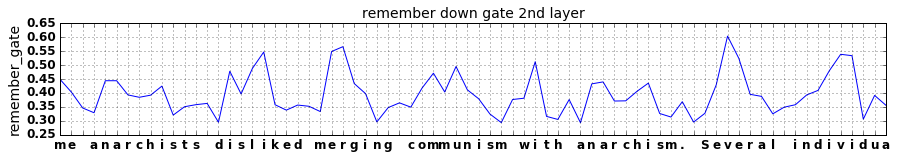

In [24]:
text_plot(gates_mean[1]['text'][3],
          gates_mean[1]['down'][3],
          'remember_gate',
          'remember down gate 2nd layer',
          ['text_plots'],
          'remember_down_2nd_layer_3',
          show=True)

[u'{', u'2', u'&', u'5', u'9', u'3', u'=', u'1', u'7', u'0', u'(', u'\n', u'8', u'6', u"'", u'4', u'}', u'\xe9', u'[', u'/', u')', u'\xf3', u',', u'.', u']', u':', u'|', u'_', u'-', u';', u' ']


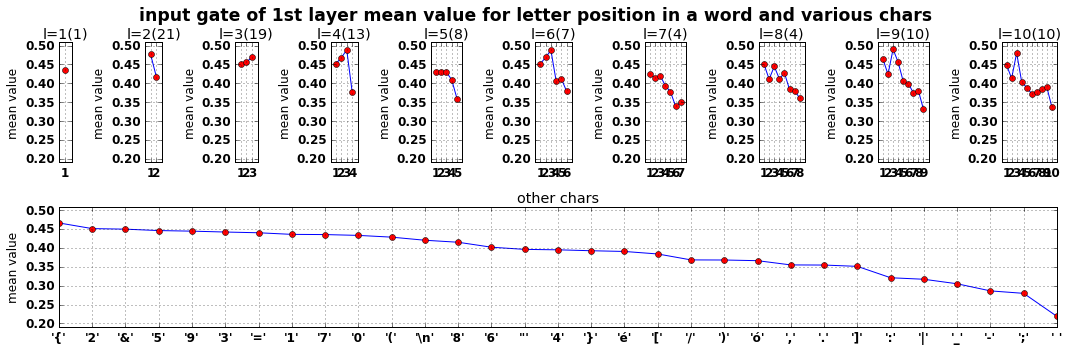

In [41]:
structure_vocabulary_plots(gates_mean[0]['text'],
                           gates_mean[0]['i'],
                           'input gate of 1st layer mean value for letter position in a word and various chars',
                           'mean value',
                           ['reverse', '2', 'gates'],
                           'mean_input1_64_16_nu_10',
                           show=True)  

[u'4', u'7', u'9', u'8', u'\xe9', u'5', u'0', u'\xf3', u'6', u'3', u'_', u'/', u'-', u',', u')', u';', u'|', u'2', u'.', u'}', u':', u"'", u']', u' ', u'1', u'&', u'[', u'{', u'=', u'\n', u'(']


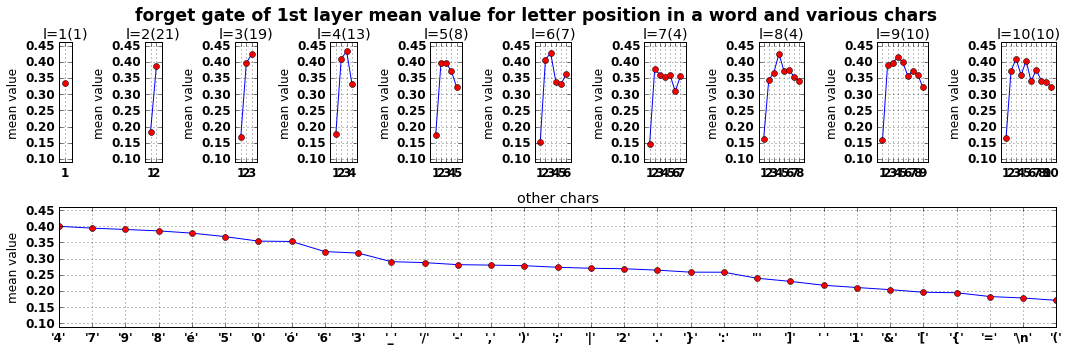

In [22]:
structure_vocabulary_plots(gates_mean[0]['text'],
                           gates_mean[0]['f'],
                           'forget gate of 1st layer mean value for letter position in a word and various chars',
                           'mean value',
                           ['reverse', '2', 'gates'],
                           'mean_forget1',
                           show=True)  

[u'9', u'\xe9', u'7', u'8', u'0', u'4', u'5', u'{', u'6', u'3', u'2', u"'", u'_', u')', u'/', u'\xf3', u'[', u'&', u'.', u'}', u',', u';', u'1', u'-', u'|', u'(', u'=', u':', u']', u'\n', u' ']


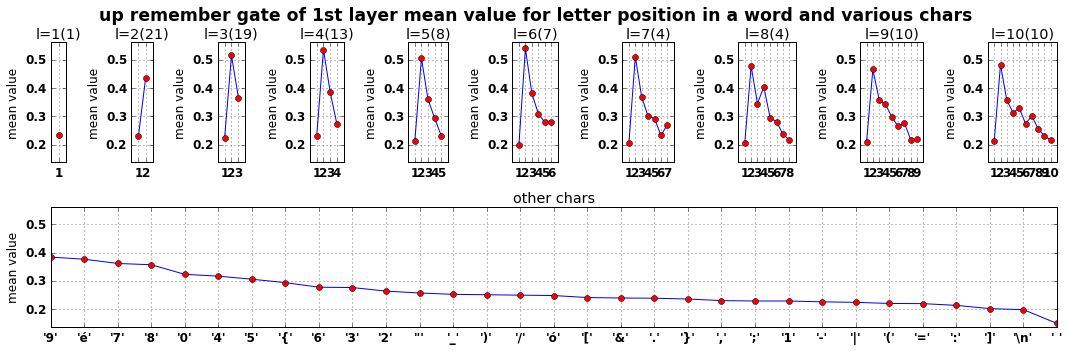

In [23]:
structure_vocabulary_plots(gates_mean[0]['text'],
                           gates_mean[0]['up'],
                           'up remember gate of 1st layer mean value for letter position in a word and various chars',
                           'mean value',
                           ['reverse', '2', 'gates'],
                           'mean_up1',
                           show=True)  

[u'9', u'1', u'2', u'7', u'&', u'3', u'0', u'8', u'5', u'6', u'4', u'\xe9', u'{', u'\xf3', u':', u'[', u'(', u'/', u'=', u'}', u'_', u"'", u';', u'|', u'\n', u',', u']', u')', u' ', u'-', u'.']


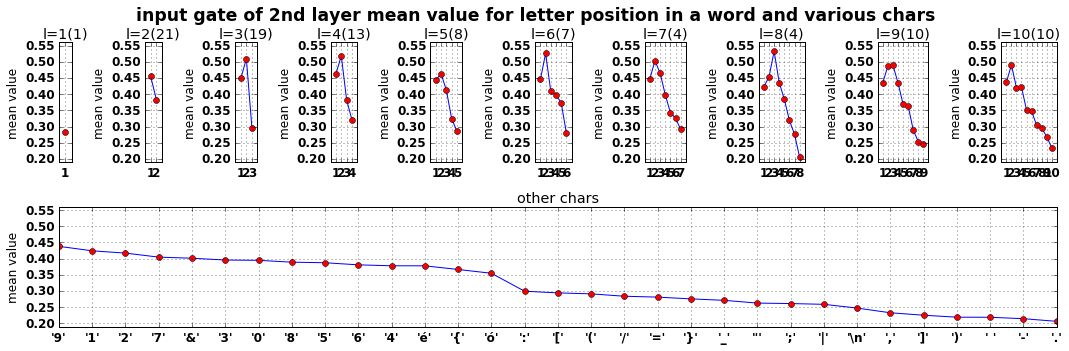

In [24]:
structure_vocabulary_plots(gates_mean[1]['text'],
                           gates_mean[1]['i'],
                           'input gate of 2nd layer mean value for letter position in a word and various chars',
                           'mean value',
                           ['reverse', '2', 'gates'],
                           'mean_input2',
                           show=True)  

[u'5', u'9', u'0', u'7', u'4', u'2', u'3', u'6', u'1', u'&', u'8', u'\xf3', u'\xe9', u'{', u"'", u':', u'_', u'/', u'=', u'}', u'[', u';', u')', u']', u'(', u',', u'|', u'-', u'\n', u'.', u' ']


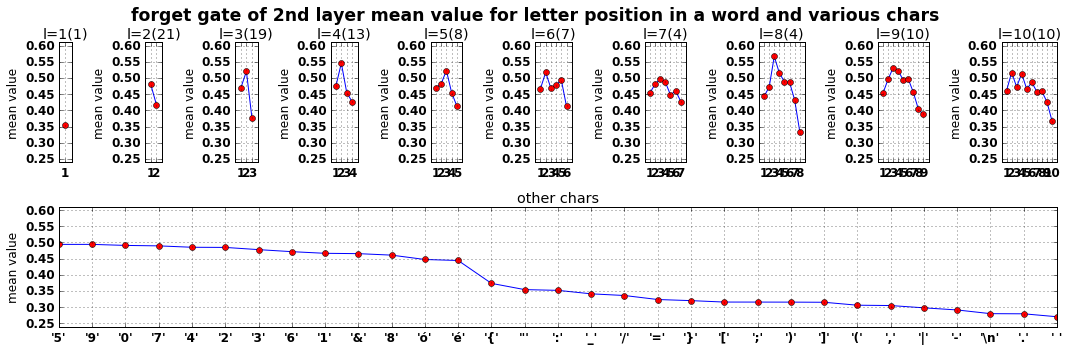

In [25]:
structure_vocabulary_plots(gates_mean[1]['text'],
                           gates_mean[1]['f'],
                           'forget gate of 2nd layer mean value for letter position in a word and various chars',
                           'mean value',
                           ['reverse', '2', 'gates'],
                           'mean_forget2',
                           show=True) 

[u'\xf3', u'\xe9', u'&', u'9', u'7', u'2', u'4', u'0', u'5', u'6', u'8', u'3', u'1', u'{', u"'", u':', u'_', u'}', u'=', u']', u'/', u')', u';', u'(', u'[', u'|', u',', u'-', u'\n', u'.', u' ']


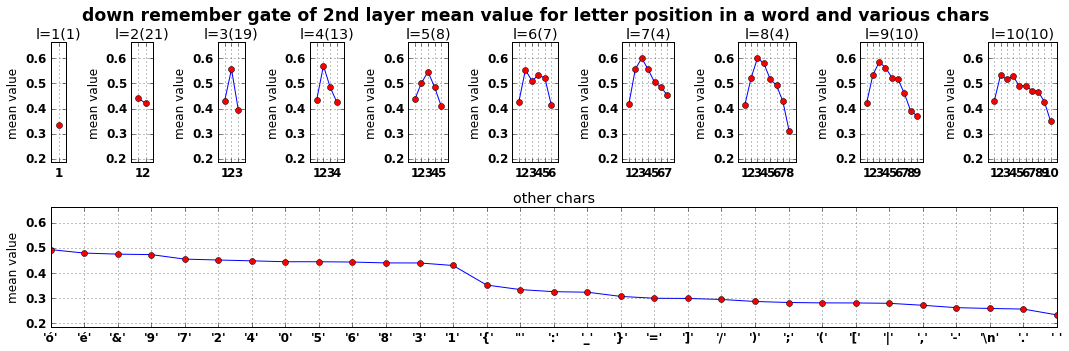

In [26]:
structure_vocabulary_plots(gates_mean[1]['text'],
                           gates_mean[1]['down'],
                           'down remember gate of 2nd layer mean value for letter position in a word and various chars',
                           'mean value',
                           ['reverse', '2', 'gates'],
                           'mean_down2',
                           show=True) 

In [2]:
fig = plt.figure()
print(fig.get_size_inches())

[ 6.  4.]


In [3]:
a = [1, 2, 3, 4]
a.sort(reverse=True)
print(a)

[4, 3, 2, 1]
